In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor
from matplotlib import pyplot as plt 
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
df=pd.read_csv('laptop_data.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [3]:
df.isnull().sum()

Company             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price               0
dtype: int64

### Data Cleaning 

In [4]:
df['Ram']=df['Ram'].str.replace('GB','')
df['Weight']=df['Weight'].str.replace('kg','')

In [5]:
df['Ram']=df['Ram'].astype('int')
df['Weight']=df['Weight'].astype('float')

In [6]:
df.dtypes

Company              object
TypeName             object
Inches              float64
ScreenResolution     object
Cpu                  object
Ram                   int32
Memory               object
Gpu                  object
OpSys                object
Weight              float64
Price               float64
dtype: object

In [7]:
df['Touchscreen']=df['ScreenResolution'].apply(lambda x:1 if 'Touchscreen' in x else 0)

In [8]:
df['Ips']=df['ScreenResolution'].apply(lambda x:1 if 'IPS' in x else 0)

In [9]:
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,Touchscreen,Ips
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832,0,1
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,47895.5232,0,0
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,30636.0000,0,0
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,135195.3360,0,1
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,96095.8080,0,1


In [10]:
df.drop(columns=['ScreenResolution'],inplace=True)

In [11]:
df['Cpu_name']=df['Cpu'].apply(lambda x:' '.join(x.split()[0:3]))

In [12]:
def processor(text):
    if text=='Intel Core i7' or text=='Intel Core i5' or text=='Intel Core i3':
        return text
    elif text.split()[0]=='Intel':
        return 'Other Intel Processor'
    else:
        return 'AMD Processor'

In [13]:
df['CPU']=df['Cpu_name'].apply(processor)

In [14]:
df.drop(columns=['Cpu','Cpu_name'],inplace=True)

In [15]:
df.head()

,Company,TypeName,Inches,Ram,Memory,Gpu,OpSys,Weight,Price,Touchscreen,Ips,CPU
0,Apple,Ultrabook,13.3,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832,0,1,Intel Core i5
1,Apple,Ultrabook,13.3,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,47895.5232,0,0,Intel Core i5
2,HP,Notebook,15.6,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,30636.0000,0,0,Intel Core i5
3,Apple,Ultrabook,15.4,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,135195.3360,0,1,Intel Core i7
4,Apple,Ultrabook,13.3,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,96095.8080,0,1,Intel Core i5


In [16]:
df['Memory'].value_counts()

256GB SSD                        412
1TB HDD                          223
500GB HDD                        132
512GB SSD                        118
128GB SSD +  1TB HDD              94
128GB SSD                         76
256GB SSD +  1TB HDD              73
32GB Flash Storage                38
2TB HDD                           16
64GB Flash Storage                15
512GB SSD +  1TB HDD              14
1TB SSD                           14
256GB SSD +  2TB HDD              10
1.0TB Hybrid                       9
256GB Flash Storage                8
16GB Flash Storage                 7
32GB SSD                           6
180GB SSD                          5
128GB Flash Storage                4
16GB SSD                           3
512GB SSD +  2TB HDD               3
128GB SSD +  2TB HDD               2
256GB SSD +  256GB SSD             2
256GB SSD +  500GB HDD             2
1TB SSD +  1TB HDD                 2
512GB Flash Storage                2
512GB SSD +  512GB SSD             1
2

In [17]:
df['Memory'] = df['Memory'].astype(str).replace('\.0', '', regex=True)
df["Memory"] = df["Memory"].str.replace('GB', '')
df["Memory"] = df["Memory"].str.replace('TB', '000')

In [18]:
new=df['Memory'].str.split('+',n=1,expand=True)

In [19]:
df['first']=new[0]
df['first']=df['first'].str.strip()

In [20]:
df["second"]= new[1]

df["Layer1HDD"] = df["first"].apply(lambda x: 1 if "HDD" in x else 0)
df["Layer1SSD"] = df["first"].apply(lambda x: 1 if "SSD" in x else 0)
df["Layer1Hybrid"] = df["first"].apply(lambda x: 1 if "Hybrid" in x else 0)
df["Layer1Flash_Storage"] = df["first"].apply(lambda x: 1 if "Flash Storage" in x else 0)

df['first'] = df['first'].str.replace(r'\D', '')

df["second"].fillna("0", inplace = True)

df["Layer2HDD"] = df["second"].apply(lambda x: 1 if "HDD" in x else 0)
df["Layer2SSD"] = df["second"].apply(lambda x: 1 if "SSD" in x else 0)
df["Layer2Hybrid"] = df["second"].apply(lambda x: 1 if "Hybrid" in x else 0)
df["Layer2Flash_Storage"] = df["second"].apply(lambda x: 1 if "Flash Storage" in x else 0)

df['second'] = df['second'].str.replace(r'\D', '')

df["first"] = df["first"].astype(int)
df["second"] = df["second"].astype(int)

df["HDD"]=(df["first"]*df["Layer1HDD"]+df["second"]*df["Layer2HDD"])
df["SSD"]=(df["first"]*df["Layer1SSD"]+df["second"]*df["Layer2SSD"])
df["Hybrid"]=(df["first"]*df["Layer1Hybrid"]+df["second"]*df["Layer2Hybrid"])
df["Flash_Storage"]=(df["first"]*df["Layer1Flash_Storage"]+df["second"]*df["Layer2Flash_Storage"])

df.drop(columns=['first', 'second', 'Layer1HDD', 'Layer1SSD', 'Layer1Hybrid',
       'Layer1Flash_Storage', 'Layer2HDD', 'Layer2SSD', 'Layer2Hybrid',
       'Layer2Flash_Storage'],inplace=True)


C:\Users\bhavy\AppData\Local\Temp/ipykernel_11900/505649735.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['first'] = df['first'].str.replace(r'\D', '')
C:\Users\bhavy\AppData\Local\Temp/ipykernel_11900/505649735.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df['second'] = df['second'].str.replace(r'\D', '')


In [21]:
df.drop('Memory',axis=1,inplace=True)
df.drop(columns=['Hybrid','Flash_Storage'],inplace=True)
df.head()

,Company,TypeName,Inches,Ram,Gpu,OpSys,Weight,Price,Touchscreen,Ips,CPU,HDD,SSD
0,Apple,Ultrabook,13.3,8,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832,0,1,Intel Core i5,0,128
1,Apple,Ultrabook,13.3,8,Intel HD Graphics 6000,macOS,1.34,47895.5232,0,0,Intel Core i5,0,0
2,HP,Notebook,15.6,8,Intel HD Graphics 620,No OS,1.86,30636.0000,0,0,Intel Core i5,0,256
3,Apple,Ultrabook,15.4,16,AMD Radeon Pro 455,macOS,1.83,135195.3360,0,1,Intel Core i7,0,512
4,Apple,Ultrabook,13.3,8,Intel Iris Plus Graphics 650,macOS,1.37,96095.8080,0,1,Intel Core i5,0,256


In [22]:
df['Gpu_brand']=df['Gpu'].str.split().apply(lambda x:x[0])

In [23]:
df['Gpu_brand'].value_counts()

Intel     722
Nvidia    400
AMD       180
ARM         1
Name: Gpu_brand, dtype: int64

In [24]:
df = df[df['Gpu_brand'] != 'ARM']
df['Gpu_brand'].value_counts()

Intel     722
Nvidia    400
AMD       180
Name: Gpu_brand, dtype: int64

In [25]:
df.drop('Gpu',axis=1,inplace=True)

In [26]:
def os(text):
    if text=='Windows 10' or text=='Windows 7' or text=='Windows 10 S':
        return 'Windows'
    elif text=='macOS' or text=='Mac OS X':
        return 'Mac'
    else:
        return 'Others/No OS/Linux'

In [27]:
df['OS']=df['OpSys'].apply(os)

In [28]:
df.drop('OpSys',axis=1,inplace=True)
df.head()

,Company,TypeName,Inches,Ram,Weight,Price,Touchscreen,Ips,CPU,HDD,SSD,Gpu_brand,OS
0,Apple,Ultrabook,13.3,8,1.37,71378.6832,0,1,Intel Core i5,0,128,Intel,Mac
1,Apple,Ultrabook,13.3,8,1.34,47895.5232,0,0,Intel Core i5,0,0,Intel,Mac
2,HP,Notebook,15.6,8,1.86,30636.0000,0,0,Intel Core i5,0,256,Intel,Others/No OS/Linux
3,Apple,Ultrabook,15.4,16,1.83,135195.3360,0,1,Intel Core i7,0,512,AMD,Mac
4,Apple,Ultrabook,13.3,8,1.37,96095.8080,0,1,Intel Core i5,0,256,Intel,Mac


### Exploratory Data Analysis 

<AxesSubplot:>

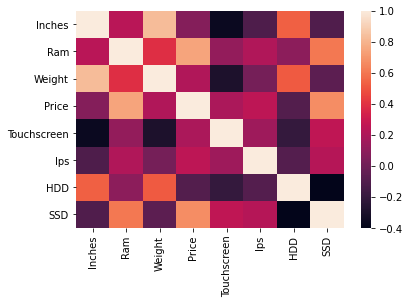

In [29]:
sns.heatmap(df.corr())

<AxesSubplot:ylabel='Density'>

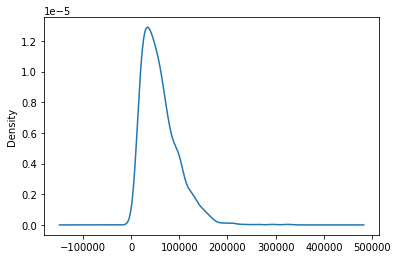

In [30]:
df['Price'].plot(kind='kde')

<AxesSubplot:ylabel='Density'>

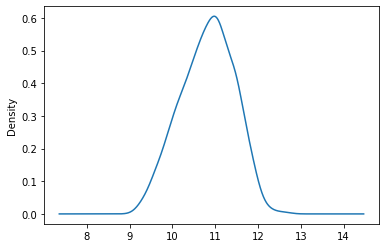

In [31]:
np.log(df['Price']).plot(kind='kde')

<AxesSubplot:>

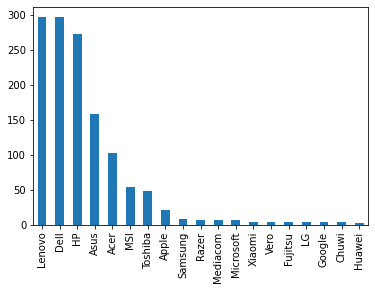

In [32]:
df['Company'].value_counts().plot(kind='bar')

Most number of laptops in the dataset come from Dell,Lenovo and HP.

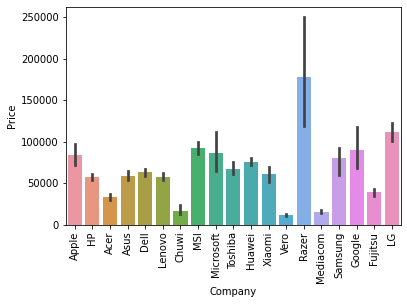

In [33]:
sns.barplot(x=df['Company'],y=df['Price'])
plt.xticks(rotation='vertical')
plt.show()

<AxesSubplot:>

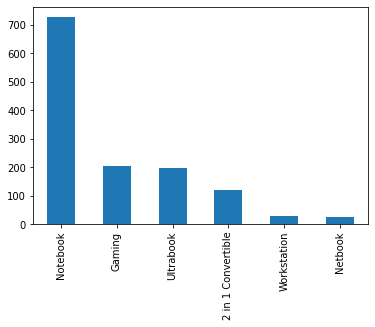

In [34]:
df['TypeName'].value_counts().plot(kind='bar')

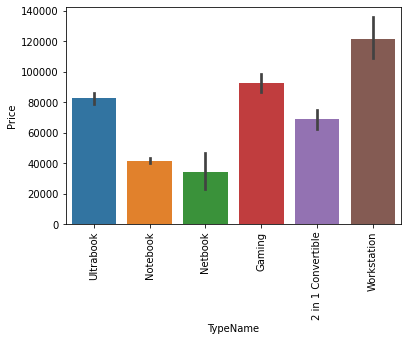

In [35]:
sns.barplot(x=df['TypeName'],y=df['Price'])
plt.xticks(rotation='vertical')
plt.show()

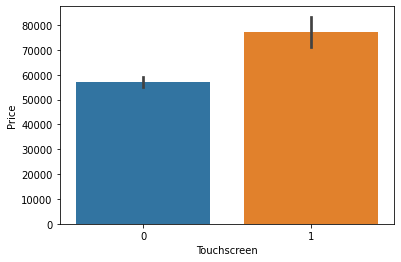

In [36]:
sns.barplot(x=df['Touchscreen'],y=df['Price'])
plt.show()

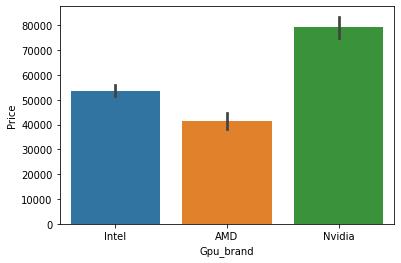

In [37]:
sns.barplot(x=df['Gpu_brand'],y=df['Price'])
plt.show()

### Model Building and Hyperparameter Tuning

In [40]:
X_temp=df.drop("Price",axis=1)
y_temp=df['Price']

X_temp_train,X_temp_test,y_temp_train,y_temp_test=train_test_split(X_temp,y_temp,test_size=0.2)

In [43]:
X_temp_train

,Company,TypeName,Inches,Ram,Weight,Touchscreen,Ips,CPU,HDD,SSD,Gpu_brand,OS
855,Dell,Notebook,15.6,8,1.900,0,0,Intel Core i5,0,128,Intel,Windows
334,Asus,Gaming,15.6,8,2.500,0,0,Intel Core i7,0,256,Nvidia,Windows
864,Dell,Ultrabook,13.3,16,1.290,1,0,Intel Core i7,0,512,Intel,Windows
800,HP,Workstation,15.6,8,3.140,0,0,Intel Core i7,0,256,Nvidia,Windows
40,Asus,Notebook,15.6,4,2.000,0,0,Intel Core i3,1000,0,Intel,Others/No OS/Linux
...,...,...,...,...,...,...,...,...,...,...,...,...
1242,Acer,Notebook,15.6,4,2.400,0,0,Intel Core i3,500,0,Intel,Others/No OS/Linux
1154,Dell,Notebook,15.6,8,2.040,1,1,Intel Core i5,0,256,Nvidia,Windows
985,Dell,Notebook,15.6,4,2.250,0,0,Intel Core i5,500,0,AMD,Windows
383,Lenovo,Notebook,14.0,8,1.500,0,1,Intel Core i5,0,256,Nvidia,Windows


In [46]:
categorical_cols=['Company','TypeName','CPU','Gpu_brand','OS']

In [47]:
df_out=pd.get_dummies(df,columns=categorical_cols)

In [50]:
X=df_out.drop('Price',axis=1)
y=np.log(df_out['Price'])

In [78]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [42]:
model1=DecisionTreeRegressor()
model1.fit(X_train,y_train)
y_preds1=model1.predict(X_test)
print('Decsion trees:',mean_absolute_error(y_test,y_preds1))

model2=RandomForestRegressor()
model2.fit(X_train,y_train)
y_preds2=model2.predict(X_test)
print('Random forest:',mean_absolute_error(y_test,y_preds2))

model3=XGBRegressor()
model3.fit(X_train,y_train)
y_preds3=model3.predict(X_test)
print('XGB:',mean_absolute_error(y_test,y_preds3))

Decsion trees: 0.2150358217320351
Random forest: 0.15276656199281496
XGB: 0.14714176011166183


In [43]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

xgbr=XGBRegressor()

reg=GridSearchCV(estimator=xgbr,param_grid=params,scoring='neg_mean_absolute_error',verbose=1)
reg.fit(X_train,y_train)

print("Best parameters:", reg.best_params_)
print("Lowest MAE: ",-reg.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500}
Lowest MAE:  0.15412641232975868


In [79]:
model4=XGBRegressor(colsample_bytree= 0.3,learning_rate= 0.05,max_depth= 10,n_estimators= 500)
model4.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [46]:
pickle.dump(df,open('df.pkl','wb'))
pickle.dump(model4,open('model4.pkl','wb'))